# 读入特征向量

In [3]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
import h5py
import numpy as np
from sklearn.utils import shuffle


feature_train,data_test,label_train,feature_val, label_val = [],[],[],[],[]


for filename in ["model_test.h5"]:    #读入事先写好特征向量
    with h5py.File(filename, 'r') as h:
        feature_train.append(np.array(h['train']))   #读入训练集特征
        label_train = np.array(h['label'])           #读入训练集标签
        
        feature_val.append(np.array(h['val']))       #读入验证集特征
        label_val = np.array(h['val_label'])         #读入验证集标签
        
        data_test.append(np.array(h['test']))        #读入测试集特征

feature_train = np.concatenate(feature_train, axis=1)  #合成一条   可以试试squminz
feature_val = np.concatenate(feature_val, axis=1)
data_test = np.concatenate(data_test, axis=1)          #合成一条
feature_train, label_train = shuffle(feature_train, label_train) #打乱训练集，使batch的数据分布能尽可能接近整个数据集的数据分布
print(type(feature_train))

<class 'numpy.ndarray'>


# 添加top层，并训练

In [10]:
input_tensor = Input(feature_train.shape[1:])
x = Dropout(0.6)(input_tensor)  #随机放弃50%
x = Dense(1, activation='sigmoid')(x)   #r全连接层，激活函数sigmoid
model = Model(input_tensor, x)

model.compile(optimizer='adadelta',loss='binary_crossentropy',metrics=['accuracy'])
#进行训练
record = model.fit(feature_train, label_train, batch_size=128, nb_epoch=7, validation_data=(feature_val, label_val))

C:\Users\Largepe\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\ipykernel\__main__.py:8: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 20000 samples, validate on 5000 samples
Epoch 1/7
20000/20000 [==============================] - 2s 84us/step - loss: 0.1472 - acc: 0.9569 - val_loss: 0.0434 - val_acc: 0.9914

# 可视化结果

C:\Users\Largepe\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


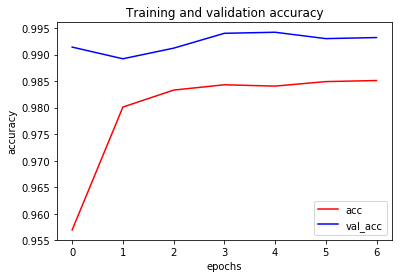

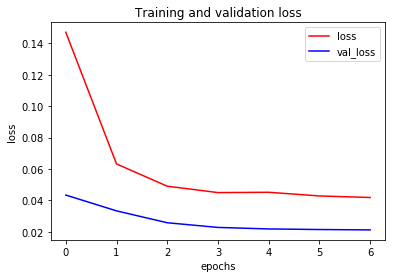

In [11]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
#画图
acc = record.history['acc']
val_acc = record.history['val_acc']
loss = record.history['loss']
val_loss = record.history['val_loss']

epochs = range(len(acc))


plt.xlabel('epochs')    #x轴名称
plt.ylabel('accuracy')  #y轴名称
plt.legend(acc='r')  
plt.plot(epochs, acc, 'r')       #训练集准确率曲线
plt.plot(epochs, val_acc, 'b')   #验证集准确率曲线
legend(loc='upper right')
plt.title('Training and validation accuracy')
plt.legend(labels = ['acc', 'val_acc'], loc = 'best')
plt.figure()



plt.xlabel('epochs')   #x轴名称
plt.ylabel('loss')     #y轴名称
plt.plot(epochs, loss, 'r')       #训练集loss曲线
plt.plot(epochs, val_loss, 'b')   #验证集loss曲线
plt.title('Training and validation loss')
plt.legend(labels = ['loss', 'val_loss'], loc = 'best')
plt.show()

# 预测测试集

In [13]:
import pandas as pd
from keras.preprocessing.image import *


result = model.predict(data_test, verbose=1)
result = result.clip(min=0.005, max=0.995)   #修剪0.005以下和0.995以上的值

temp_file = pd.read_csv("sample_submission.csv")

image_generator = ImageDataGenerator()  #因为已经导出了特征向量，所以前面程序可以不运行，所以这里需要新建generator
test_generator = image_generator.flow_from_directory("test_data", (224, 224), shuffle=False, batch_size=16, class_mode=None)

for i, fname in enumerate(test_generator.filenames):    #记录预测结果
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    #index = int(fname[fname.rfind('\\')+1:fname.rfind('.')])  #windows 用此命令代替上一行
    temp_file.set_value(index-1, 'label', result[i])

temp_file.to_csv('result.csv', index=None)  #将预测结果写入.csv文件
temp_file.head(10)

12500/12500 [==============================] - 0s 20us/step
Found 12500 images belonging to 1 classes.


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005


# 最终kaggle最好得分为0.04187

In [14]:
from IPython.display import Image
from IPython.core.display import HTML 
a = result[8]*100

print("这张图有 %f"%a+"% "+"的可能性是狗:")
Image(url= 'test\\10004.jpg')



这张图有 99.282951% 的可能性是狗:
